### 1. Biased-Persistent motion

A BP walker is defined by three parameters $w, p$ and $b$. At each time step biased motion is chosen with probability $w$ and persistent with probability $1-w$. An angle is draw from the distribution 

$$
N_{\text{w}} ( \alpha_t | \, \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} \sum_{k=-\infty}^{\infty} \exp \big[ - \frac{(\alpha_{t} - \mu + 2 \pi k)^{2}}{2 \sigma ^{2}
} \big].
$$

If biased motion occurs then $\mu = \beta_t$ and $\sigma = - 2\log(b)$. If persistent motion occurs, then $\mu = \alpha_{t-1}$ and $\sigma = - 2\log(p)$

All angles are defined with reference to the negative $y$-axis

<img src="images/bias-persistent-cropped-1.png" alt="drawing" width="400"/>



### 2. Inference on biased-persistent trajectories

This notebook describes how you can do basic MCMC inference on biased-persistent trajectory data. The likelihood function, for a set of parameters $\Theta$ given $N$ sets of trajectories $\{ \pi_i \}$ is given as 

$$
L(\Theta) = \prod^{N}_{i=0} p\,(\pi_{i} \,|\, \Theta)
$$

Converting this path $\pi_i$ into a set of angle observations $\alpha^{i}_{t}$ and holding simulteneously the direction to the source at each step $\beta^{i}_{t}$ one can break down this probability into 

$$
p\,(\pi_{i} \,|\, \Theta) = \underbrace{p\,(\alpha^{i}_{0} \, | \, \Theta, \, \beta^{i}_{0} )}_{\text{only biased motion possible}} \, \prod^{T}_{t=1} \underbrace{p \, (\alpha^{i}_{t} \, | \, \Theta, \, \alpha^{i}_{t-1}, \, \beta^{i}_{t} ) }_{\text{biased or persistent motion possible}}. 
$$

Note that on the first step only biased motion is possible, that is 

$$
p\,(\alpha^{i}_{0} \, | \, \Theta, \, \beta^{i}_{0} ) =  N_{\text{w}} ( \alpha^{i}_{0} \, | \, \beta^{i}_{0}, \, \sigma_{b})
$$

and 

$$
p \, (\alpha^{i}_{t} \, | \, \Theta, \, \alpha^{i}_{t-1}, \, \beta^{i}_{t} ) = w N_{\text{w}} ( \alpha^{i}_{t} \, | \, \beta^{i}_{t}, \, \sigma_{b}) + (1-w)N_{\text{w}} ( \alpha^{i}_{t} \, | \, \alpha_{t-1}^{i}, \, \sigma_{p}).
$$

where $N_{\text{w}}$ is the wrapped normal distribution as defined in section 1. 



### 3. MCMC

With a set of starting parameters $\Theta_0$ one can successively update and get a stationary distribution by applying Markov Chain Monte Carlo algorithms. The Metropolis Hastings version has an update probability 

$$
P(\Theta \rightarrow \Theta') = \text{min} \Big( 1, \, \frac{L(\Theta')\,  q(\Theta)}{L(\Theta) \, q(\Theta')} \Big)
$$

where $\Theta'$ is a randomly chosen move in some direction in parameter space and $q(\Theta)$ is a prior. This could simply be a uniform distribution over the interval $[0, 1]$ for each of $w, p, b$. In this case the update rule would become

$$
P(\Theta \rightarrow \Theta') = \begin{cases}
    0, & \text{if $w, p$ or $b$ outside of $[0, 1]$}.\\
    \text{min} \Big( 1, \, \frac{L(\Theta')}{L(\Theta)} \Big), & \text{otherwise}.
  \end{cases} 
$$

### 4. Numerical stability

The multiplication together of many probabilities gets very small very quickly. We can get around this by using logarithms. Note that 

$$
\begin{align}
\log \big( L(\Theta) \big) &= \log \big( \prod^{N}_{i=0} p\,(\alpha^{i}_{0} \, | \, \Theta, \, \beta^{i}_{0} ) \, \prod^{T}_{t=1} p \, (\alpha^{i}_{t} \, | \, \Theta, \, \alpha^{i}_{t-1}, \, \beta^{i}_{t} ) \Big) \\
&= \sum_{i=0}^{N} \log \Big(  p\,(\alpha^{i}_{0} \, | \, \Theta, \, \beta^{i}_{0} ) \, \prod^{T}_{t=1} p \, (\alpha^{i}_{t} \, | \, \Theta, \, \alpha^{i}_{t-1}, \, \beta^{i}_{t} ) \Big)\\
&= \sum_{i=0}^{N} \Big[ \log \big( p\,(\alpha^{i}_{0} \, | \, \Theta, \, \beta^{i}_{0} ) \big) + \, \sum^{T}_{t=1} \log \big( p \, (\alpha^{i}_{t} \, | \, \Theta, \, \alpha^{i}_{t-1}, \, \beta^{i}_{t} ) \big) \Big]
\end{align}
$$

Then when evaluating the fraction in the MCMC update, 

$$
\begin{align}
\frac{L(\Theta')}{L(\Theta)} &= \frac{\exp \big( \log ( L(\Theta') ) \big) }{\exp \big( \log ( L(\Theta) ) \big) } \\
&= \exp \big( \log ( L(\Theta') ) - \log ( L(\Theta) ) \big)
\end{align}
$$

So we can recover the fraction we need without having to lose precision with the multiplication of many many probabilities

Von Mises distribution
Information Theory, Inference and Learning Algoririthms

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
np.linspace(-5, 5, 101)

array([-5. , -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -4.1, -4. , -3.9, -3.8, -3.7, -3.6, -3.5, -3.4, -3.3, -3.2, -3.1, -3. , -2.9, -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. , -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,
        3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ])

In [5]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook
np.set_printoptions(precision=6, linewidth=500, threshold=500, suppress=True)

In [6]:
import os
import sys
import time
sys.path.append(os.path.abspath('..'))

from utils.distributions import wrapped_normal_sample, bernoulli, truncated_normal_sample
from utils.plotting import add_pi_ticks
from utils.angles import angle_between
from utils.parallel import parallel_methods

ImportError: cannot import name 'wrapped_normal_sample' from 'utils.distributions' (/home/ed/Documents/Academic/Edinburgh/Courses/Dissertation/LeukocyteMigration/utils/distributions.py)

In [5]:
from scipy.stats import gaussian_kde
from scipy.optimize import minimize

### 5. Set up a basic source model

It directs all movement towards the origin

In [6]:
# THIS IS MY SUPER BASIC SOURCE DEFINITION
source_coords = np.array([0, 0])

# use negative y-axis as the reference axis. All angles will be measured against this
reference_axis = np.array([0, -1]) 

# super simple source model
def direction_to_source(coords: np.array) -> np.array:
    return source_coords - coords

### 6. Set up a basic biased-persistent random walker

In [7]:
def BP_walk(X0: np.array, T: int, w: float, p: float, b:float) -> np.array:
    """
    Perform a biased-persistent random walk from starting point X0, for T time steps
    with parameters w, p, b.
    
    Returns:
        np.array (T+1, 2): the x-y coordinates of the path traversed beginning at X0
    """

    path = np.zeros((T + 1, 2))
    path[0, :] = X0
    biased = bernoulli(w, T)  # pre-determine all the b/p decisions in vector form

    sig_b = -2 * np.log(b)
    sig_p = -2 * np.log(p)

    for i, bias in enumerate(biased):
        current_position = path[i]
        dir_to_source = direction_to_source(current_position)

        if bias or i == 0:
            sig = sig_b
            mu = angle_between(reference_axis, dir_to_source)
        else:
            sig = sig_p
            mu = previous_angle
        if np.isinf(sig):
            sig = 100

        alpha = wrapped_normal_sample(mu, sig)
        previous_angle = alpha
        s = truncated_normal_sample(0.2)
        dx = s * np.sin(alpha)
        dy = s * np.cos(alpha)
        path[i + 1, 0] = path[i, 0] + dx
        path[i + 1, 1] = path[i, 1] - dy 

    return path

### 7. Generate some walker trajectories

<IPython.core.display.Javascript object>


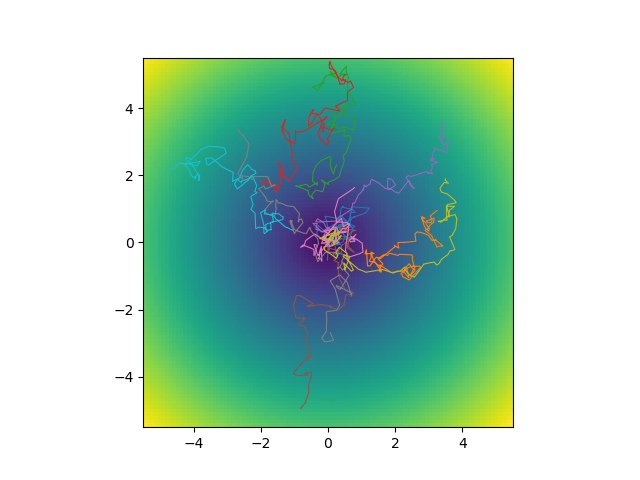

In [8]:
n_walkers = 10
T = 100
w = 0.3
b = 0.7
p = 0.5

paths = np.concatenate([BP_walk(np.random.uniform(-5, 5, size=(2,)), T, w, p, b)[:, :, None] for i in range(n_walkers)], axis=2)

plt.figure()
X, Y = np.meshgrid(np.linspace(-5, 5, 101), np.linspace(-5, 5, 101))
plt.imshow((X ** 2 + Y ** 2) ** 0.5, extent=(-5.5, 5.5, -5.5, 5.5))
for i in range(n_walkers):
    plt.plot(paths[:, 0, i], paths[:, 1, i], linewidth=0.8)

### 8. Write a vectorised function for evaluating wrapped normal pdf

<IPython.core.display.Javascript object>


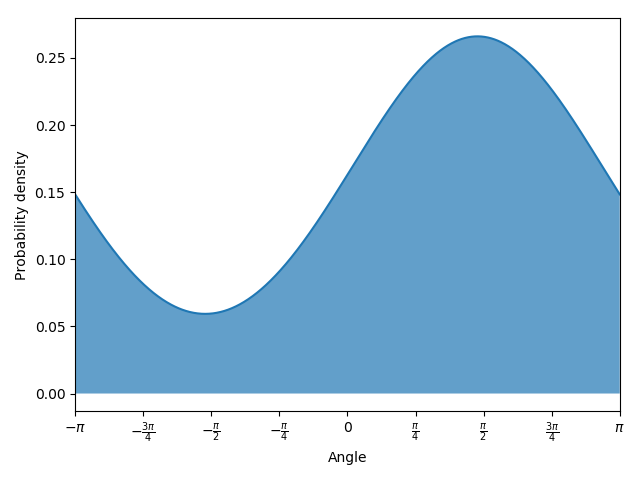

In [9]:
def normal_pdf(x: np.array, mu: np.array, sig: np.array) -> np.array:
    """
    Get the value of the normal distribution pdf function for set of points x.
    """
    return (1 / (sig * (2 * np.pi) ** 0.5)) * np.exp(- (x - mu) ** 2 / (2 * sig ** 2))

def wrapped_normal_pdf(x: np.array, mu: np.array, sig: float) -> np.array:
    """
    For a set of points x, get the value of the probability density
    function for a wrapped normal distribution at these points. 
    Each point in x can come from a distribution with a different
    mean, but all distributions must have the same variance. Hence
    mu can be a numpy array, but sig must be a float. 
    """

    # if sigma is greater than 6, the difference between it and a uniform distribution is ~1e-8
    if sig > 6:
        if isinstance(x, np.ndarray):
            return np.ones_like(x) / (2 * np.pi)
        else:
            return 1 / (2 * np.pi)
    if sig == 0:
        return mu

    # *blindly* opt for 5 loops either side
    
    # mu =  [ mu1   ,  mu2   ,  mu3   ,  mu4   ]
    
    #          .        .        .        .
    #          .        .        .        .
    # X =   [a - 2pi, b - 2pi, c - 2pi, d - 2pi] 
    #       [   a   ,    b   ,    c   ,    d   ]
    #       [a + 2pi, b + 2pi, c + 2pi, d + 2pi]
    #       [a + 4pi, b + 4pi, c + 4pi, d + 4pi]
    #          .        .        .        .
    #          .        .        .        .

    # then sum(normal(X, mu=mu), axis=0)

    return normal_pdf(np.array([x + 2 * np.pi * i for i in range(-4, 5)]), mu, sig).sum(0)

fig, ax = plt.subplots()
x = np.linspace(-np.pi, np.pi, 1001)
y = wrapped_normal_pdf(x, 1.5, 1.5)
plt.plot(x, y)
plt.xlim((-np.pi, np.pi))
ax.fill_between(x, 0, y, alpha=0.7)
add_pi_ticks(ax)
plt.xlabel('Angle')
plt.ylabel('Probability density')
plt.tight_layout()

### 9. Set up an inference pipeline

In [12]:
class BPbayesian:

    def __init__(self, paths: np.array, direction_to_source: object):

        """
        Params:

            paths:                np.array - (T+1, 2, N) - paths of N walkers walking for T timesteps
            direction_to_source:  a function that takes array([x, y]) and returns the direction to the source.

        """

        self.paths = paths
        self.direction_to_source = direction_to_source
        alphas, betas = self.convert_path(paths)
        self.alphas = alphas
        self.betas = betas

    def convert_path(self, paths: np.array):
        """
        Given a set of raw x-y coordinates, get a list of the alphas and betas

        Params:

            paths:                np.array - (T+1, 2, N) - paths of N walkers walking for T timesteps
            reference_axis:       np.array - (2, ) direction which angles should be measured around
            direction_to_source:  a function that takes array([x, y]) and returns the direction to the source.

        Returns:

            alphas:    np.array - (T, N): angle taken at each time step
            betas:     np.array - (T, N): direction to source at each time step

        """

        moves = paths[1:, :, :] - paths[:-1, :, :]
        alphas = np.apply_along_axis(lambda move: angle_between(reference_axis, move), 1, moves)
        d_to_sources = np.apply_along_axis(self.direction_to_source, 1, paths)
        betas = np.apply_along_axis(lambda d: angle_between(reference_axis, d), 1, d_to_sources)[:-1, :]

        return alphas, betas

    def log_likelihood(self, w: float, p: float, b: float) -> float:
        """
        Get the log-likelihood of a set of parameters w, p, b. This is a vectorised version which
        is considerably faster.

        Params:

            w:    The variable w which defines the probability of taking a biased step
            p:    The variable p, defining the variance of persistent motion
            b:    The variable b, defining the variance of boased motion

        Returns:
            

        """

        sig_b = -2 * np.log(b)
        sig_p = -2 * np.log(p)
        log_prob = 0

        for walker in range(self.alphas.shape[1]):

            alphas = self.alphas[1:, walker]
            alpha_prevs = self.alphas[:-1, walker]
            betas = self.betas[1:, walker]

            p_0 = wrapped_normal_pdf(self.alphas[0, walker], self.betas[0, walker], sig_b)
            p_t = w * wrapped_normal_pdf(alphas, betas, sig_b) + (1 - w) * wrapped_normal_pdf(alphas, alpha_prevs, sig_p)

            log_prob += np.log(p_0)
            log_prob += np.log(p_t).sum()

        return log_prob
    
#     def Q(self, step, w, p, b):
        

    def infer(self, w0: float, p0: float, b0: float,
              step: float=0.02,
              n_steps: int=10000,
              burn_in: int=3000, 
              seed: int=0) -> np.array:
        """
        Given a set of starting parameters, perform MCMC bayesian inference for n_steps with 
        a burn in of burn_in and a maximum step size in each direction of step_size
        
        Params:

            w0:    The starting point for w
            p0:    The starting point for p
            b0:    The starting point for b

        Returns:

            params:    np.array, shape: (n_steps, 3) -> the distribution over parameters
            
        """
        
        np.random.seed(seed)

        params = []
        
        w, p, b = w0, p0, b0
        w1, w2 = max(w - step, 0), min(w + step, 1)
        p1, p2 = max(p - step, 0), min(p + step, 1)
        b1, b2 = max(b - step, 0), min(b + step, 1)
        Q_t = 1 / ((w2 - w1) * (p2 - p1) * (b2 - b1)) #the value of the new proposal pdf

        L_t = self.log_likelihood(w, p, b)

        for i in range(n_steps + burn_in):

            # add random purturbation to w, p, b
            w_ = np.random.uniform(w1, w2)
            p_ = np.random.uniform(p1, p2)
            b_ = np.random.uniform(b1, b2)
            
            w1_, w2_ = max(w_ - step, 0), min(w_ + step, 1)
            p1_, p2_ = max(p_ - step, 0), min(p_ + step, 1)
            b1_, b2_ = max(b_ - step, 0), min(b_ + step, 1)
            
            Q_ = 1 / ((w2 - w1) * (p2 - p1) * (b2 - b1)) #the value of the new proposal pdf

            # evaluate the log-likelihood of our proposed move
            L_ = self.log_likelihood(w_, p_, b_)
            
            # evaluate the probability of moving
            prob = np.exp(L_ - L_t) * (Q_t / Q_)
            
            # decide whether to move
            if np.random.uniform(0, 1) < prob:
                w, p, b = w_, p_, b_
                L_t = L_
                w1, w2, p1, p2, b1, b2 = w1_, w2_, p1_, p2_, b1_, b2_
            if i >= burn_in:
                params.append([w, p, b])

        return np.array(params)
    
    def multi_infer(self, n_walkers: int=5, 
                    step: float=0.02,
                    n_steps: int=10000,
                    burn_in: int=3000, 
                    sneaky_init: bool=True):
        '''
        Use multiple MCMC walkers in parallel
        '''

        objs = [self for i in range(n_walkers)]
        methods = ['infer' for i in range(n_walkers)]
        
        if sneaky_init:
            w0, p0, b0 = self.most_probable()
            params = [{'w0': w0, 
                       'p0': p0, 
                       'b0': b0, 
                       'step': step, 
                       'n_steps': n_steps, 
                       'burn_in': 0, 
                       'seed': i} for i in range(n_walkers)]
            
        else:
            params = [{'w0': np.random.uniform(0, 1), 
                       'p0': np.random.uniform(0, 1), 
                       'b0': np.random.uniform(0, 1), 
                       'step': step, 
                       'n_steps': n_steps, 
                       'burn_in': burn_in, 
                       'seed': i} for i in range(n_walkers)]
        
        res = parallel_methods(objs, methods, params, backend='multiprocessing')
        
        try:
            return np.concatenate(res, axis=0)
        except ValueError:
            print([r.shape for r in res])
            return np.concatenate([r for r in res if r.shape == (n_steps, 3)], axis=0)
        
    def most_probable(self, method: str='SLSQP'):
        '''
        Use scipy optimiser to find the most probable set of parameters
        '''
        
        z = minimize(lambda x: -self.log_likelihood(*x), x0=(0.5, 0.5, 0.5), method=method, bounds=[(0.01, 1) for i in range(3)])
        return z.x
        

/home/ed/miniconda3/envs/diss/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log
/home/ed/miniconda3/envs/diss/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in log
/home/ed/miniconda3/envs/diss/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in log


<IPython.core.display.Javascript object>


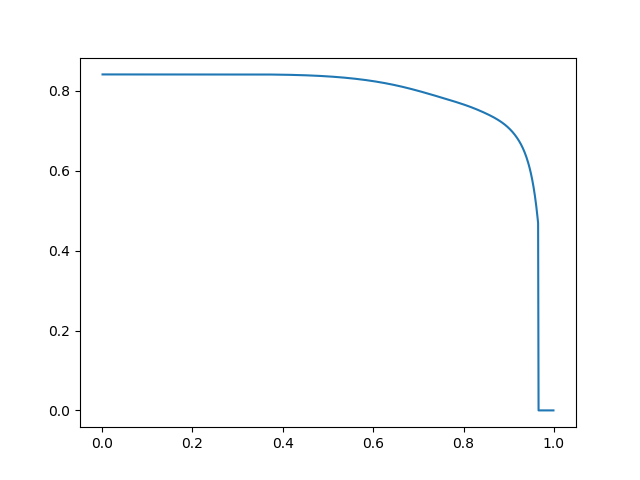

In [44]:
n_walkers = 10
T = 100
w = 0.6
b = 0.3
p = 0.7

paths = np.concatenate([BP_walk(np.random.uniform(-5, 5, size=(2,)), T, w, p, b)[:, :, None] for i in range(n_walkers)], axis=2)
BI = BPbayesian(paths, direction_to_source)

bs = np.linspace(0.001, 1, 1001)
pdfs = 1.0001 ** np.array([BI.log_likelihood(w, p, b) for b in bs])
  
plt.figure()
plt.plot(bs, pdfs)



In [41]:
1.0001 ** -1722

0.8418180417113162

In [39]:
pdfs

array([-1724.248071, -1724.248071, -1724.248071, ..., -1723.204815, -1723.222465, -1723.240347])

<IPython.core.display.Javascript object>


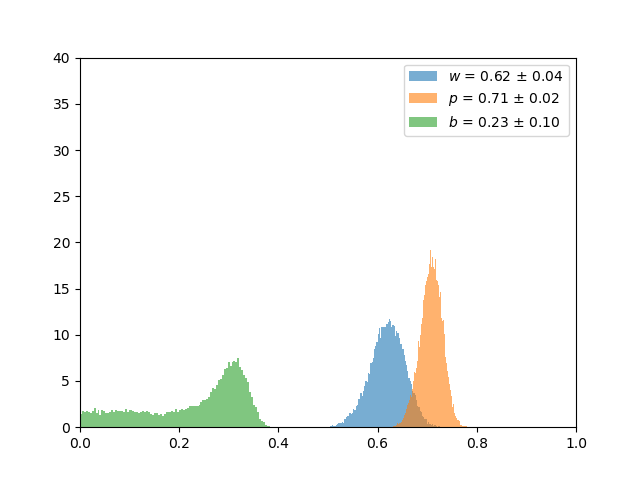

completed in 22.79s


/home/ed/miniconda3/envs/diss/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log
/home/ed/miniconda3/envs/diss/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


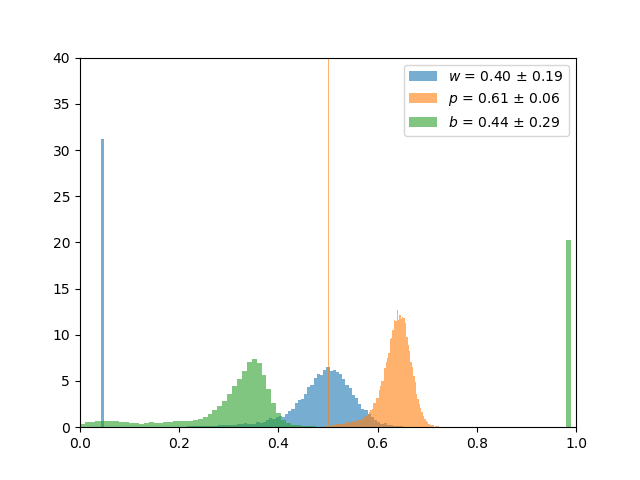

completed in 22.40s


<IPython.core.display.Javascript object>


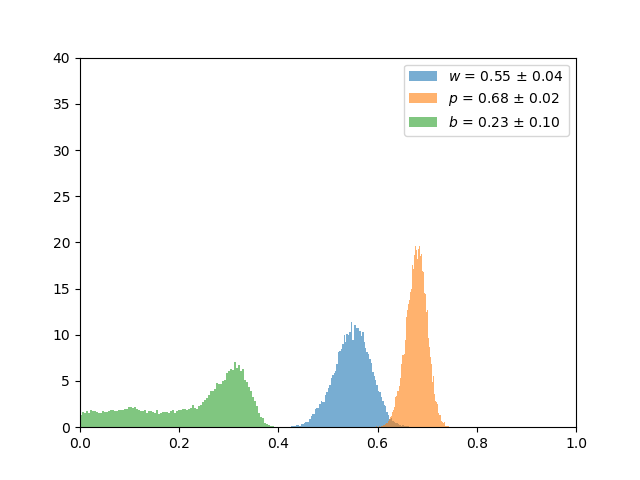

completed in 21.90s


/home/ed/miniconda3/envs/diss/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Javascript object>


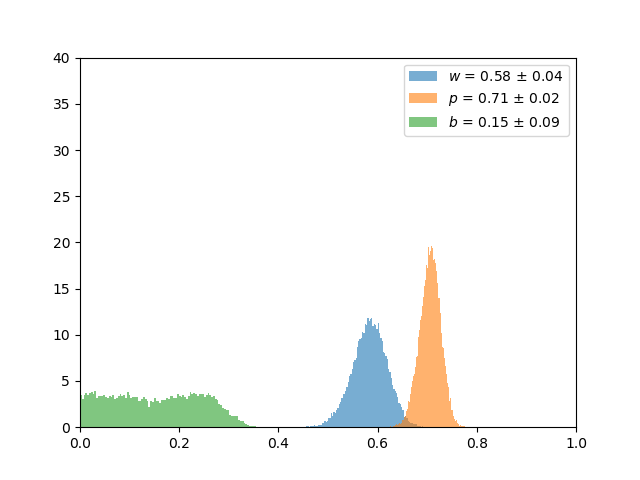

completed in 22.10s


<IPython.core.display.Javascript object>


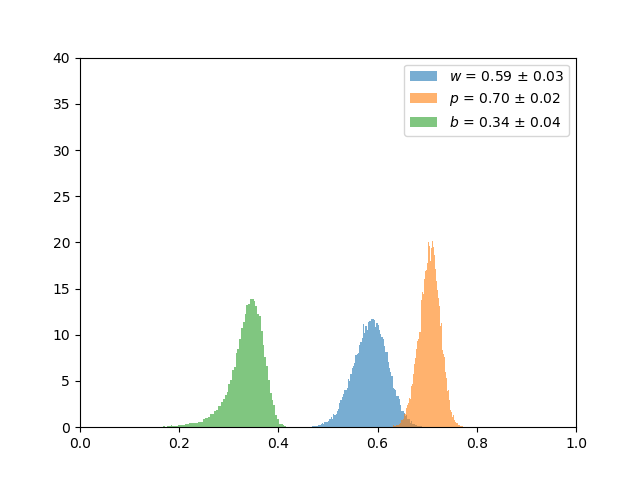

completed in 24.80s


<IPython.core.display.Javascript object>


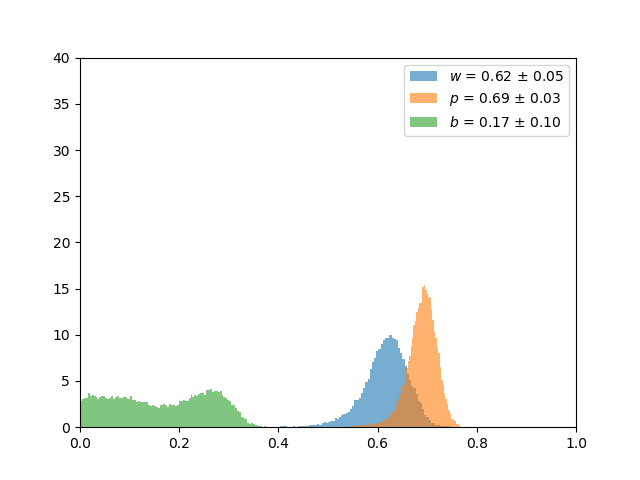

completed in 21.40s


<IPython.core.display.Javascript object>


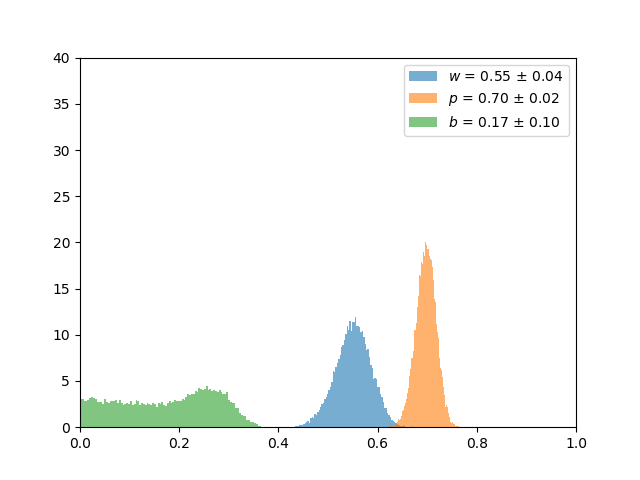

completed in 23.70s


<IPython.core.display.Javascript object>


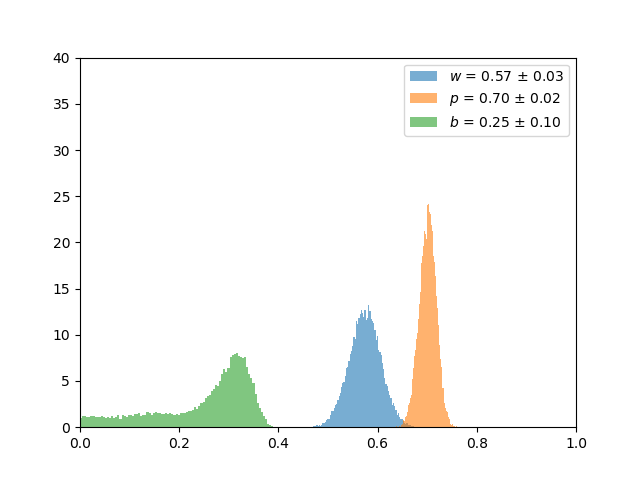

completed in 22.41s


/home/ed/miniconda3/envs/diss/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Javascript object>


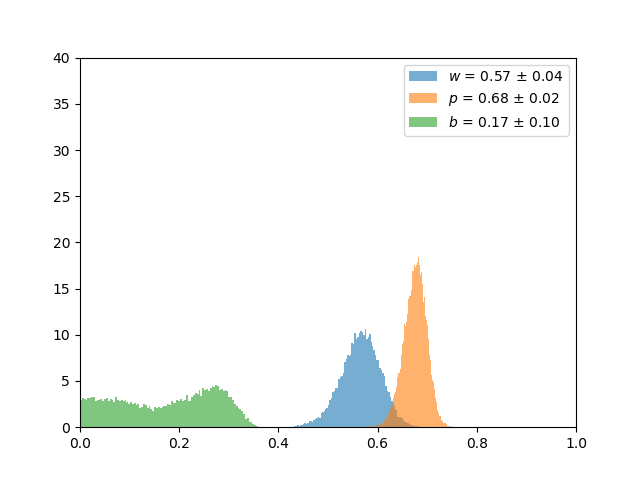

completed in 21.31s


<IPython.core.display.Javascript object>


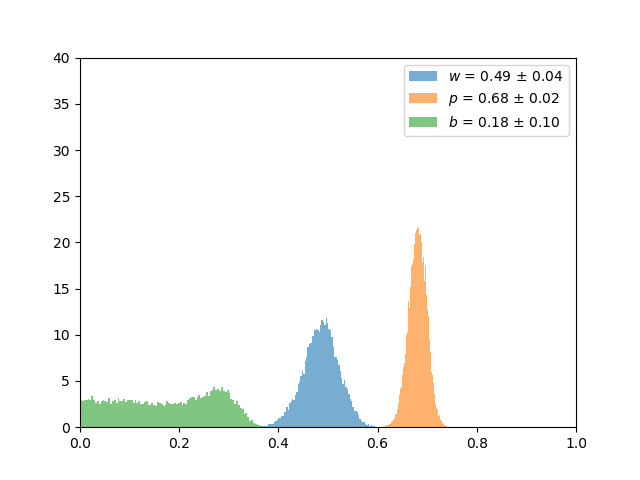

completed in 21.02s


/home/ed/miniconda3/envs/diss/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log
/home/ed/miniconda3/envs/diss/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


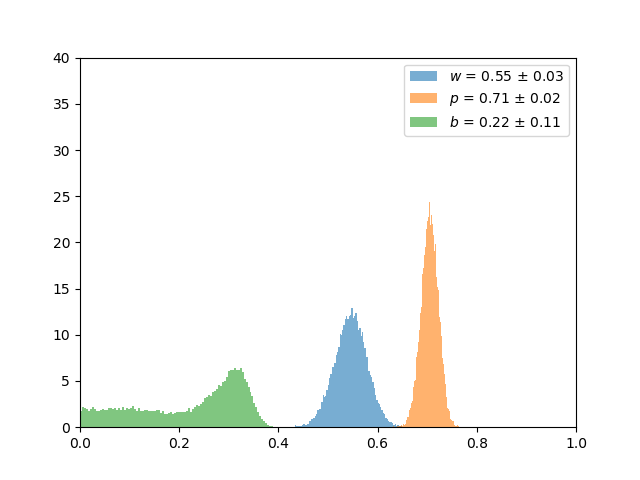

completed in 21.92s


<IPython.core.display.Javascript object>


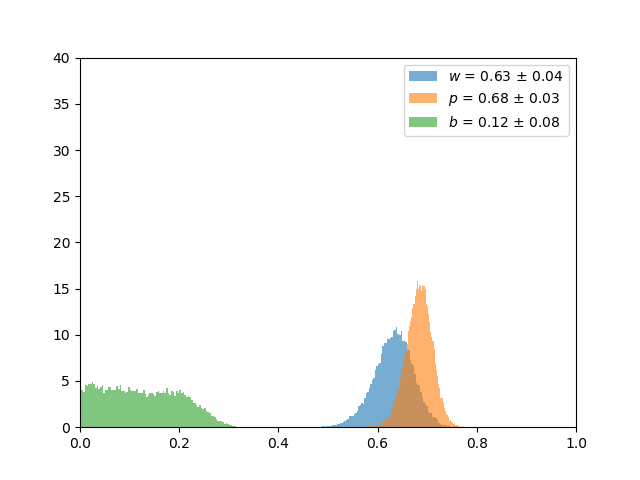

completed in 21.12s


<IPython.core.display.Javascript object>


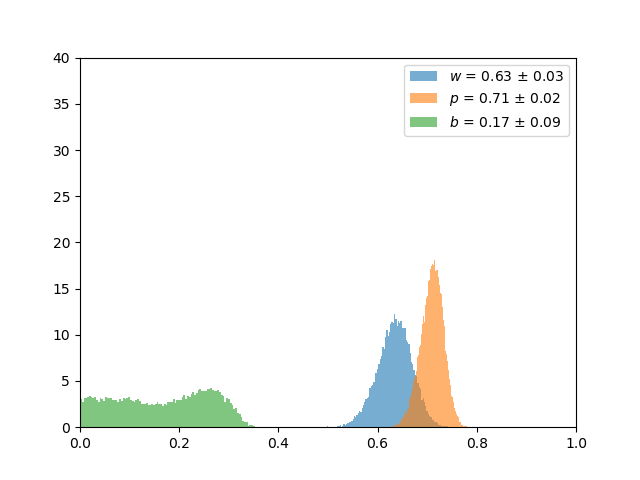

completed in 21.52s


<IPython.core.display.Javascript object>


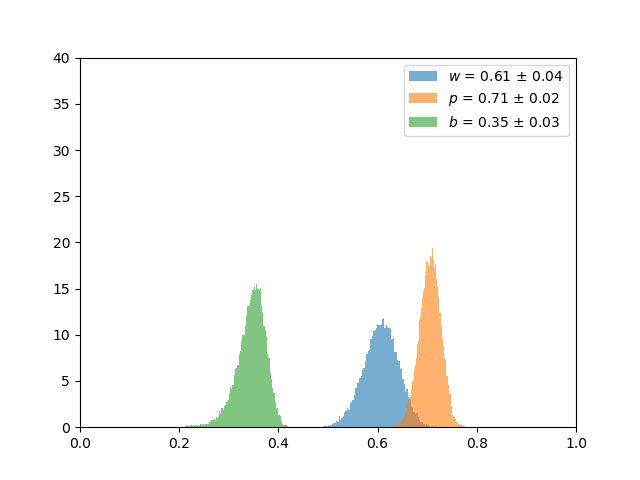

completed in 20.94s


/home/ed/miniconda3/envs/diss/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Javascript object>


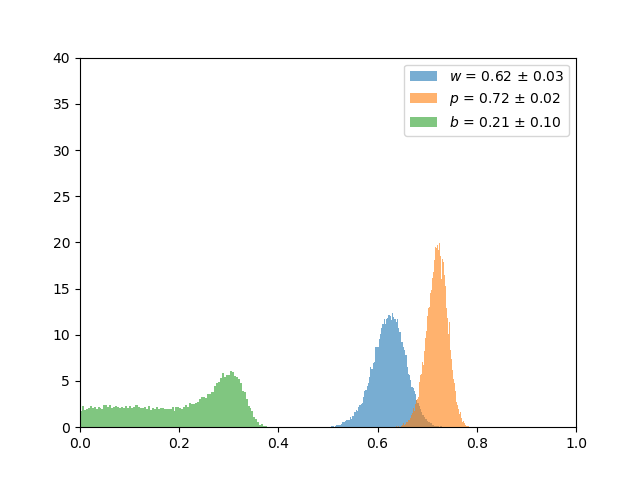

completed in 23.33s


<IPython.core.display.Javascript object>


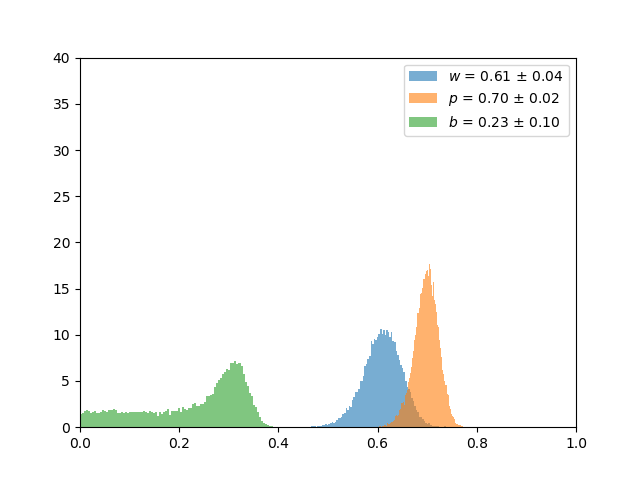

completed in 22.04s


<IPython.core.display.Javascript object>


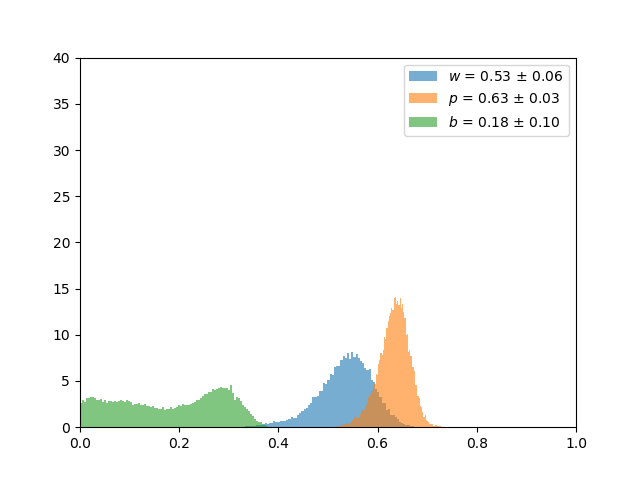

completed in 21.35s


<IPython.core.display.Javascript object>


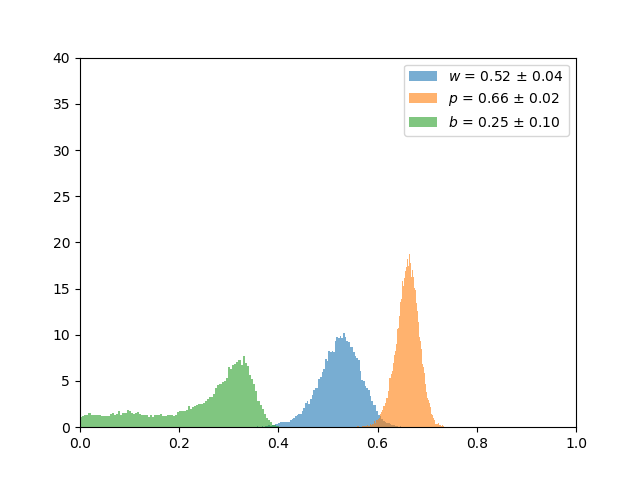

completed in 22.35s


/home/ed/miniconda3/envs/diss/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log
/home/ed/miniconda3/envs/diss/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in double_scalars
/home/ed/miniconda3/envs/diss/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


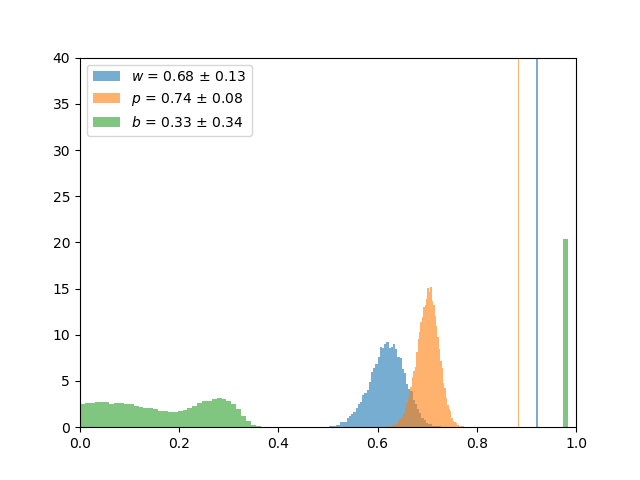

completed in 22.06s


<IPython.core.display.Javascript object>


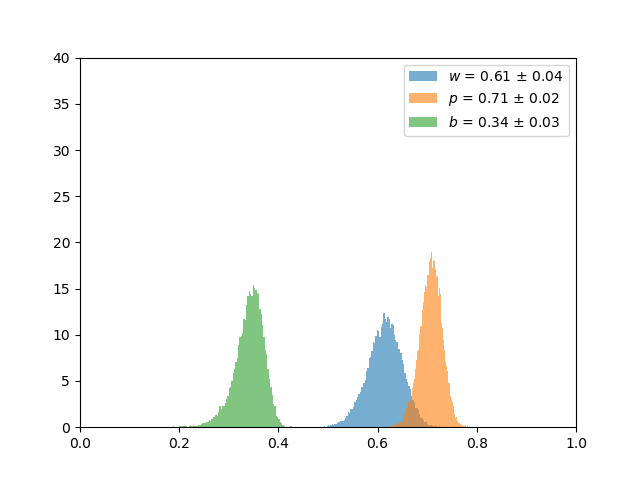

completed in 22.70s


In [17]:
n_walkers = 10
T = 100
w = 0.6
b = 0.3
p = 0.7

for i in range(20):
    
    np.random.seed(i) 
    paths = np.concatenate([BP_walk(np.random.uniform(-5, 5, size=(2,)), T, w, p, b)[:, :, None] for i in range(n_walkers)], axis=2)

    t1 = time.time()
    BI = BPbayesian(paths, direction_to_source)

    params = BI.multi_infer(n_walkers=5, 
                            step=0.02,
                            n_steps=10000,
                            burn_in=3000, 
                            sneaky_init=False)

    plot(params)

    t2 = time.time()

    print('completed in {:.2f}s'.format(t2-t1))


In [24]:
gaussian_kde?

In [42]:
kde.logpdf(0.9)[0]

-33471.57665603559

<IPython.core.display.Javascript object>


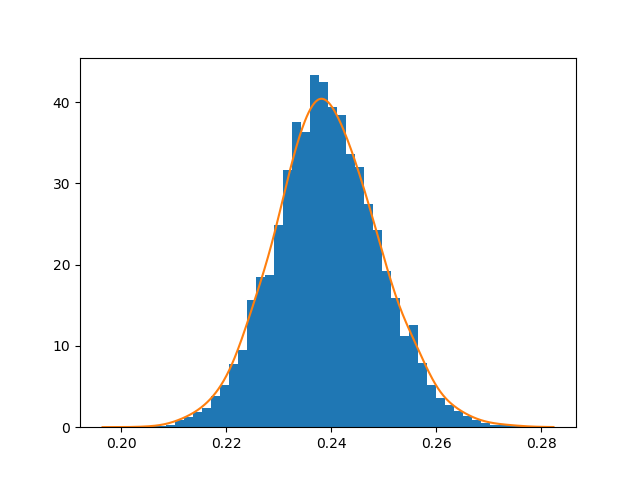

In [25]:
wb = params[:, 0] * params[:, 2]
x = np.linspace(min(wb), max(wb), 500)
kde = gaussian_kde(wb)
kde.set_bandwidth(0.25)
y = kde(x)
plt.figure()
plt.hist(wb, bins=50, density=True)
plt.plot(x, y)
plt.savefig('wb.png')

### 10. RUN

### 11. PLOT

Remember, the true walker was defined with parameters $w=0.3, p=0.7, b=0.7$

In [6]:
np.arange?


In [7]:
import numpy as np
np.arange(10, 200.1, 10)

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.,
       120., 130., 140., 150., 160., 170., 180., 190., 200.])

In [10]:
cols = {'w': '#1f77b4', 'p': '#ff7f0e', 'b': '#2ca02c'}

def plot(params: np.array, title: str=None):
    """
    params: np.array, shape: (n_steps - burn_in, 3) -> the parameters observed 
    """

    plt.figure()
    stds = np.std(params, 0)
    means = np.mean(params, 0)
    

    for i, typ in enumerate(['w', 'p', 'b']):
        plt.hist(params[:, i], label='${}$ = {:.2f} $\pm$ {:.2f}'.format(typ, means[i], stds[i]), bins=100, alpha=0.6, density=True, color=cols[typ])

    plt.legend()
    plt.xlim(0, 1)
    plt.ylim(0, 40)
    plt.title(title)
    

    
# for i in range(1, 11):
    
#     n_walkers = 5 * i
#     T = 100
#     w = 0.6
#     b = 0.3
#     p = 0.7

#     paths = np.concatenate([BP_walk(np.random.uniform(-5, 5, size=(2,)), T, w, p, b)[:, :, None] for i in range(n_walkers)], axis=2)
    
#     t1 = time.time()
#     BI = BPbayesian(paths, direction_to_source)
#     params = BI.multi_infer(n_walkers=5, 
#                             step=0.02,
#                             n_steps=10000,
#                             burn_in=3000)
    
#     t2 = time.time()
    
#     plot(params, title='5 MCMC walkers. {} Leukocytes. Time: {:.2f}s'.format(i * 5, t2 - t1))
#     x = np.linspace(0, 1, 500)
#     y1 = gaussian_kde(params[:, 0])(x)
#     y2 = gaussian_kde(params[:, 1])(x)
#     y3 = gaussian_kde(params[:, 2])(x)
#     plt.plot(x, y1, color=cols['w'])
#     plt.plot(x, y2, color=cols['p'])
#     plt.plot(x, y3, color=cols['b'])

#     plt.xlabel('Value')
#     plt.ylabel('Probability Density')
#     plt.savefig('{}_Leukocytes.png'.format(i*5))

### 12. Grid Search

In [12]:
import pandas as pd
from utils.parallel import parallel_functions

In [19]:
n_walkers = 10
T = 100

def infer(w, b, p):
    paths = np.concatenate([BP_walk(np.random.uniform(-5, 5, size=(2,)), T, w, p, b)[:, :, None] for i in range(n_walkers)], axis=2)
    BI = BPbayesian(paths, direction_to_source)
    w0, p0, b0 = np.random.uniform(0, 1, 3)
    t0 = time.time()
    params = BI.infer(w0, p0, b0,
                      n_steps=10000,
                      burn_in=3000)
    t1 = time.time()
    stds = np.std(params, 0)
    means = np.mean(params, 0)
    row = [w, p, b, w0, p0, b0, means[0], means[1], means[2], stds[0], stds[1], stds[2], t1 - t0]
    
    return np.array(row)

steps = np.arange(0.1, 1, 0.1) 
params = [{'w': w, 'b': b, 'p': p} for w in steps for b in steps for p in steps]
rows = np.array(parallel_functions([infer] * len(params), params=params, backend='multiprocessing', n_jobs=6))




/home/ed/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
/home/ed/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in double_scalars
/home/ed/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
/home/ed/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in double_scalars
/home/ed/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
/home/ed/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
/home/ed/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in double_scalars
/home/ed/miniconda3/envs/diss

[[ 0.1       0.1       0.1      ...  0.080047  0.16882  12.054093]
 [ 0.1       0.2       0.1      ...  0.083753  0.109298 18.590836]
 [ 0.1       0.3       0.1      ...  0.079627  0.081595 19.397032]
 ...
 [ 0.9       0.7       0.9      ...  0.019956  0.002451 18.160404]
 [ 0.9       0.8       0.9      ...  0.012192  0.002483 15.952049]
 [ 0.9       0.9       0.9      ...  0.008962  0.002395 13.17633 ]]


In [26]:
df = pd.DataFrame(rows, columns=['w', 'p', 'b', 'w0', 'p0', 'b0', 'w_mean', 'p_mean', 'b_mean', 'w_std', 'p_std', 'b_std', 'time'])
for t in ['w', 'b', 'p']:
    df['{}_err'.format(t)] = np.abs(df[t] - df['{}_mean'.format(t)])

In [27]:
df

,w,p,b,w0,p0,b0,w_mean,p_mean,b_mean,w_std,p_std,b_std,time,w_err,b_err,p_err
0,0.1,0.1,0.1,0.014420,0.196245,0.146320,0.181683,0.136031,0.351568,0.118362,0.080047,0.168820,12.054093,0.081683,0.251568,0.036031
1,0.1,0.2,0.1,0.014420,0.196245,0.146320,0.262169,0.162636,0.195477,0.153528,0.083753,0.109298,18.590836,0.162169,0.095477,0.037364
2,0.1,0.3,0.1,0.014420,0.196245,0.146320,0.585866,0.408340,0.129669,0.158683,0.079627,0.081595,19.397032,0.485866,0.029669,0.108340
3,0.1,0.4,0.1,0.014420,0.196245,0.146320,0.359421,0.482698,0.149232,0.240542,0.075009,0.101564,19.829827,0.259421,0.049232,0.082698
4,0.1,0.5,0.1,0.014420,0.196245,0.146320,0.183539,0.524970,0.214034,0.119155,0.031599,0.112267,20.238389,0.083539,0.114034,0.024970
5,0.1,0.6,0.1,0.014420,0.196245,0.146320,0.101409,0.598466,0.261233,0.043333,0.015939,0.121650,13.646684,0.001409,0.161233,0.001534
6,0.1,0.7,0.1,0.347227,0.292858,0.843618,0.104561,0.704423,0.196133,0.017367,0.008435,0.088639,13.313192,0.004561,0.096133,0.004423
7,0.1,0.8,0.1,0.420046,0.336401,0.743535,0.102972,0.803375,0.128637,0.013385,0.005147,0.108506,12.484192,0.002972,0.028637,0.003375
8,0.1,0.9,0.1,0.948070,0.228222,0.653542,0.120699,0.898335,0.088117,0.012817,0.002697,0.064875,17.951873,0.020699,0.011883,0.001665
9,0.1,0.1,0.2,0.601681,0.467851,0.153625,0.507008,0.175211,0.124962,0.216766,0.099692,0.080059,17.888132,0.407008,0.075038,0.075211


<IPython.core.display.Javascript object>


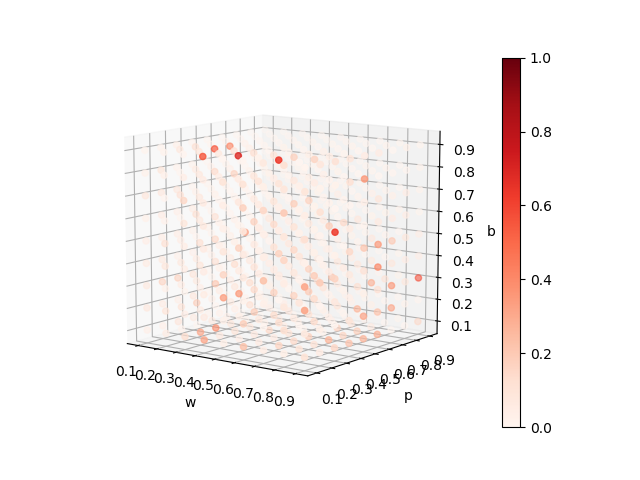

In [72]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.cm as cmx

def plot_error(which='w', colormap='Reds'):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    cm = plt.get_cmap(colormap)
    cNorm = matplotlib.colors.Normalize(0, 1)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    scalarMap.set_array(df['{}_err'.format(which)])
    fig.colorbar(scalarMap)

    ax.scatter(df['w'], df['p'], df['b'], c=scalarMap.to_rgba(df['{}_err'.format(which)]), marker='o')
    ax.set_xlabel('w')
    ax.set_ylabel('p')
    ax.set_zlabel('b')
    plt.show()
    
plot_error('p')

In [44]:
df[df['w_err'] > 0.6]

,w,p,b,w0,p0,b0,w_mean,p_mean,b_mean,w_std,p_std,b_std,time,w_err,b_err,p_err
18,0.1,0.1,0.3,0.816836,0.880076,0.076990,0.817067,0.169307,0.105852,1.303747e-01,9.495241e-02,7.192152e-02,10.708859,0.717067,0.194148,0.069307
20,0.1,0.3,0.3,0.100450,0.041673,0.355241,0.734062,0.481241,0.104240,1.429795e-01,1.244569e-01,7.036322e-02,16.726012,0.634062,0.195760,0.181241
163,0.3,0.2,0.1,0.765521,0.165513,0.598274,0.916942,0.519003,0.133771,8.951438e-02,2.527839e-01,6.863401e-02,11.943074,0.616942,0.033771,0.319003
164,0.3,0.3,0.1,0.593495,0.606263,0.108584,0.904903,0.695191,0.140326,7.545266e-02,1.827080e-01,7.377118e-02,20.104876,0.604903,0.040326,0.395191
202,0.3,0.5,0.5,0.958038,0.132010,0.987634,0.958038,0.132010,0.987634,1.998401e-15,9.242607e-15,1.776357e-15,11.230409,0.658038,0.487634,0.367990
236,0.3,0.3,0.9,0.870104,0.950859,0.702078,0.955007,0.844818,0.439241,1.773874e-02,5.452213e-02,1.082391e-02,21.620509,0.655007,0.460759,0.544818
568,0.8,0.2,0.1,0.702332,0.202718,0.358580,0.182170,0.109933,0.230489,1.635208e-01,6.840812e-02,1.103747e-01,11.225713,0.617830,0.130489,0.090067
578,0.8,0.3,0.2,0.078926,0.788686,0.228276,0.114903,0.166499,0.253362,8.177381e-02,7.672418e-02,1.334100e-01,19.257871,0.685097,0.053362,0.133501
591,0.8,0.7,0.3,0.332649,0.705073,0.175948,0.148283,0.412174,0.459884,1.670624e-01,4.452346e-02,1.508464e-01,21.473615,0.651717,0.159884,0.287826
592,0.8,0.8,0.3,0.048813,0.687618,0.991766,0.048813,0.687618,0.991766,4.676814e-15,6.461498e-14,1.665335e-14,15.601602,0.751187,0.691766,0.112382
